In [1]:
!pip install indic-nlp-library
!pip install pandas pyarrow

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import fasttext
import fasttext.util

cuda_available = torch.cuda.is_available()
print("CUDA Available:", cuda_available)
device = torch.device("cuda" if cuda_available else "cpu")

class ELMoLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(ELMoLanguageModel, self).__init__()
        self.forward_lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.forward_lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.backward_lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.backward_lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)

        self.forward_pred = nn.Linear(hidden_dim, vocab_size)
        self.backward_pred = nn.Linear(hidden_dim, vocab_size)
        self.gamma = nn.Parameter(torch.ones(3))  
        self.freeze_parameters()
        
    def freeze_parameters(self):
        for name, param in self.named_parameters():
            if 'gamma' not in name:
                param.requires_grad = False

    def forward(self, x):
        
        forward_out1, _ = self.forward_lstm1(x)
        forward_out2, _ = self.forward_lstm2(forward_out1)

      
        reversed_embeddings = torch.flip(x, [1])
        backward_out1, _ = self.backward_lstm1(reversed_embeddings)
        backward_out2, _ = self.backward_lstm2(backward_out1)

        backward_out1 = torch.flip(backward_out1, [1])
        backward_out2 = torch.flip(backward_out2, [1])

        forward_predictions = self.forward_pred(forward_out2[:, -1, :])
        backward_predictions = self.backward_pred(backward_out2[:, 0, :])

        
        combined_embeddings = self.gamma[0] * x + self.gamma[1] * torch.cat((forward_out1, backward_out1), dim=-1) + self.gamma[2] * torch.cat((forward_out2, backward_out2), dim=-1)

        return forward_predictions, backward_predictions, combined_embeddings
    
    
import json
import torch

def load_model_and_mappings(model_path, mappings_path):
    with open(mappings_path, 'r', encoding='utf-8') as f:
        mappings = json.load(f)

    token_to_index = mappings['token_to_index']
    vocab_size = len(token_to_index) + 1 

    model = ELMoLanguageModel(vocab_size, 300, 150).to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()  
    
    return model, token_to_index


model_path = '/kaggle/input/final-elmo-model/bilm_marathi_model (1).pth'
mappings_path = '/kaggle/input/final-elmo-model/marathi_mappings.json'
elmo_model, token_to_index = load_model_and_mappings(model_path, mappings_path)

ft_model = fasttext.load_model('/kaggle/input/pre-trained-model-indicft/indicnlp.ft.mr.300.bin')

def load_dataset(parquet_path):
    
    return pd.read_parquet(parquet_path)

train_path = '/kaggle/input/ner-marathi/train-00000-of-00001.parquet'
test_path = '/kaggle/input/ner-marathi/test-00000-of-00001.parquet'
val_path = '/kaggle/input/ner-marathi/validation-00000-of-00001.parquet'

train_df = load_dataset(train_path)
test_df = load_dataset(test_path)
val_df = load_dataset(val_path)

print("Train Dataset:", train_df.head())
print("Test Dataset:", test_df.head())
print("Validation Dataset:", val_df.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.3 MB/s eta 0:00:00
CUDA Available: True


Train Dataset:                                               tokens  \
0            [पुनर्निर्देशन, चंद्रशेखर, वेंकट, रामन]   
1            [येथे, सप्तशृंगी, देवीचे, देउळ, आहे, .]   
2  [राष्ट्रपतिपदाच्या, निवडणुकीस, उभे, राहण्याअगो...   
3             [पुनर्निर्देशन, गुरदयाल, सिंग, धिल्लन]   
4        [पुनर्निर्देशन, जॉन, जोसेफ, काल्डवेल, अॅबट]   

                         ner_tags  \
0                    [6, 2, 5, 5]   
1              [6, 1, 4, 6, 6, 6]   
2  [6, 6, 6, 6, 6, 1, 4, 6, 6, 6]   
3                    [6, 2, 5, 5]   
4                 [6, 2, 5, 5, 5]   

                                     additional_info  
0  [[None], [चंद्रशेखर_वेंकट_रामन, चंद्रशेखर_वेंक...  
1  [[None], [सप्तशृंगी_देवी, सप्तशृंगी_देवीचे, OR...  
2  [[None], [None], [None], [None], [None], [भारत...  
3  [[None], [गुरदयाल_सिंग_धिल्लन, गुरदयाल_सिंग_धि...  
4  [[None], [जॉन_जोसेफ_काल्डवेल_अॅबट, जॉन_जोसेफ_क...  
Test Dataset:                                               tokens               ner_tags  \
0 

### 1.1 Baseline

train_loss,█▃▂▁▁
train_loss,0.08288


100%|██████████| 380/380 [00:13<00:00, 29.17it/s]


Epoch 1: Loss 0.41862493498544945


100%|██████████| 380/380 [00:13<00:00, 28.88it/s]


Epoch 2: Loss 0.179477498601926


100%|██████████| 380/380 [00:12<00:00, 29.24it/s]


Epoch 3: Loss 0.13650998878047654


100%|██████████| 380/380 [00:13<00:00, 28.73it/s]


Epoch 4: Loss 0.10462240873786964


100%|██████████| 380/380 [00:13<00:00, 29.10it/s]


Epoch 5: Loss 0.08037462851130649


100%|██████████| 380/380 [00:12<00:00, 31.27it/s]


              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6257
           1       0.96      0.91      0.94      3520
           2       0.98      0.99      0.98      5180
           3       0.94      0.93      0.94      3379
           4       0.97      0.97      0.97      8175
           5       0.99      0.99      0.99      7908
           6       0.99      0.99      0.99     52267

    accuracy                           0.98     86686
   macro avg       0.97      0.97      0.97     86686
weighted avg       0.98      0.98      0.98     86686



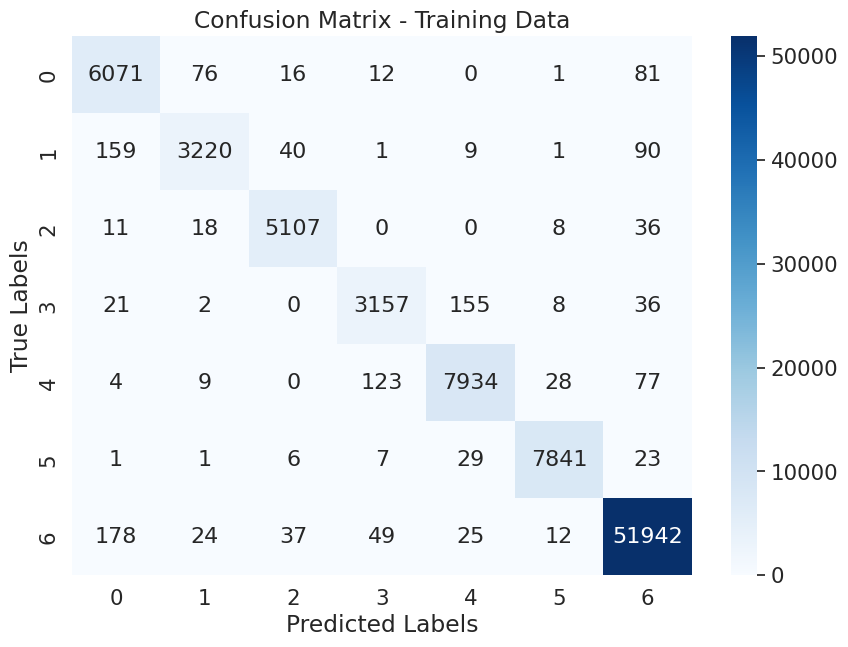

100%|██████████| 42/42 [00:01<00:00, 28.41it/s]


              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1056
           1       0.83      0.80      0.82       335
           2       0.90      0.91      0.91       446
           3       0.90      0.80      0.85       456
           4       0.89      0.91      0.90       774
           5       0.96      0.93      0.95       799
           6       0.98      0.98      0.98      7161

    accuracy                           0.95     11027
   macro avg       0.91      0.89      0.90     11027
weighted avg       0.95      0.95      0.95     11027



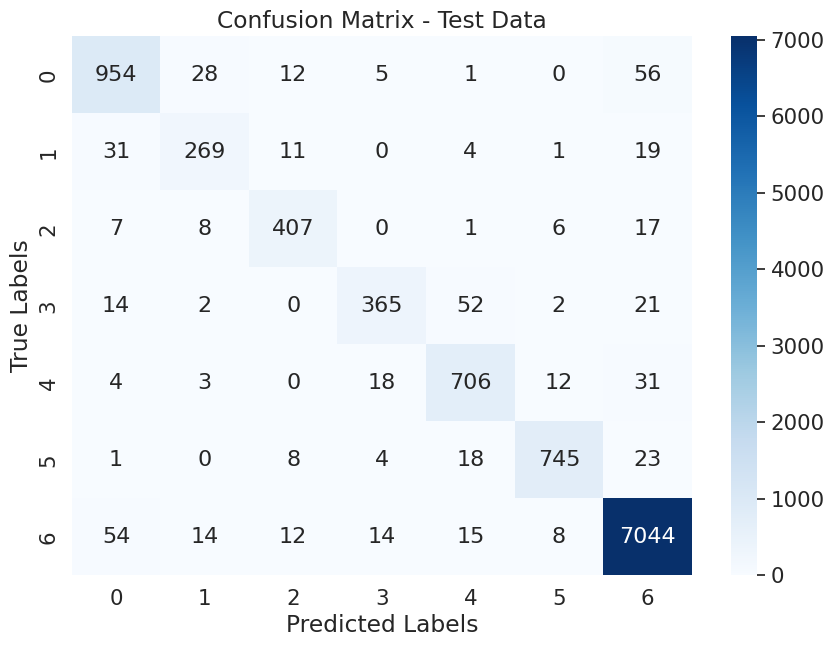

In [10]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from indicnlp.tokenize import indic_tokenize
from tqdm import tqdm
import wandb
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class NERDataset(Dataset):
    def __init__(self, dataframe, ft_model, tokenizer, tag_to_index):
        self.dataframe = dataframe
        self.ft_model = ft_model
        self.tokenizer = tokenizer
        self.tag_to_index = tag_to_index

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        tokens = self.dataframe.iloc[idx]['tokens']
        ner_tags = self.dataframe.iloc[idx]['ner_tags']
        
        embeddings = [self.ft_model.get_word_vector(token) for token in tokens]
        embeddings = torch.tensor(embeddings, dtype=torch.float)

        tag_indices = [self.tag_to_index[tag] for tag in ner_tags]
        tag_indices = torch.tensor(tag_indices, dtype=torch.long)

        return embeddings, tag_indices
    
def collate_fn(batch):
    embeddings, tags = zip(*batch)
    embeddings_padded = pad_sequence(embeddings, batch_first=True, padding_value=0)
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=-1)

    return embeddings_padded, tags_padded

class NERModel(nn.Module):
    def __init__(self, hidden_dim, num_tags):
        super(NERModel, self).__init__()
        self.lstm = nn.LSTM(300, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_tags)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_tags = len(tag_to_index)  
hidden_dim = 150
model = NERModel(hidden_dim, num_tags).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


wandb.init(project='ELMO_FOR_INDIAN_LANGUAGES_GROUP-30', name="Downtask4-Train_baseline_Marathi")
for epoch in range(5):
    model.train()
    total_loss = 0
    for embeddings, tags in tqdm(train_loader):
        embeddings, tags = embeddings.to(device), tags.to(device)
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs.view(-1, num_tags), tags.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    wandb.log({"train_loss": total_loss / len(train_loader)})
    print(f"Epoch {epoch+1}: Loss {total_loss / len(train_loader)}")

def evaluate_accuracy(model, data_loader, device):
    model.eval()
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for embeddings, tags in tqdm(data_loader):
            embeddings, tags = embeddings.to(device), tags.to(device)
            outputs = model(embeddings)
            outputs = outputs.cpu().detach().numpy()
            tags = tags.cpu().detach().numpy()
            for i in range(outputs.shape[0]):
                valid_length = int((tags[i] >= 0).sum())
                all_outputs.extend(outputs[i, :valid_length].tolist())
                all_labels.extend(tags[i, :valid_length].tolist())
    return np.array(all_outputs), np.array(all_labels)

train_embeddings, train_labels = evaluate_accuracy(model, train_loader, device)
predicted_labels_train = np.argmax(train_embeddings, axis=1)
print(classification_report(train_labels, predicted_labels_train))
cm = confusion_matrix(train_labels, predicted_labels_train)
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

test_embeddings, test_labels = evaluate_accuracy(model, test_loader, device)
predicted_labels = np.argmax(test_embeddings, axis=1)
print(classification_report(test_labels, predicted_labels))
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 1.2 ELMO

train_loss,█▃▂▁▁
train_loss,0.02405


100%|██████████| 380/380 [00:15<00:00, 24.23it/s]


Epoch 1: Loss 0.3210200085157627


100%|██████████| 380/380 [00:15<00:00, 24.25it/s]


Epoch 2: Loss 0.12146310148466574


100%|██████████| 380/380 [00:15<00:00, 23.93it/s]


Epoch 3: Loss 0.07073035074005786


100%|██████████| 380/380 [00:15<00:00, 24.29it/s]


Epoch 4: Loss 0.03658268325104329


100%|██████████| 380/380 [00:15<00:00, 24.20it/s]


Epoch 5: Loss 0.01900546980078185


100%|██████████| 380/380 [00:14<00:00, 25.96it/s]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6257
           1       1.00      0.99      1.00      3520
           2       1.00      1.00      1.00      5180
           3       0.99      0.98      0.98      3379
           4       0.99      0.99      0.99      8175
           5       1.00      1.00      1.00      7908
           6       1.00      1.00      1.00     52267

    accuracy                           1.00     86686
   macro avg       1.00      0.99      1.00     86686
weighted avg       1.00      1.00      1.00     86686



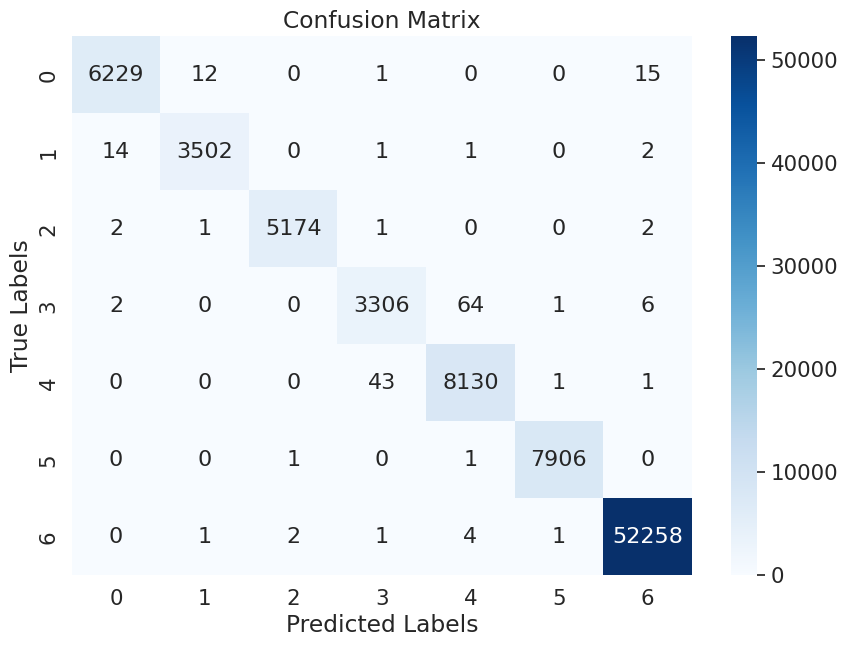

100%|██████████| 42/42 [00:01<00:00, 22.52it/s]


              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1056
           1       0.84      0.82      0.83       335
           2       0.92      0.92      0.92       446
           3       0.93      0.80      0.86       456
           4       0.91      0.92      0.91       774
           5       0.96      0.93      0.94       799
           6       0.97      0.99      0.98      7161

    accuracy                           0.95     11027
   macro avg       0.92      0.90      0.91     11027
weighted avg       0.95      0.95      0.95     11027



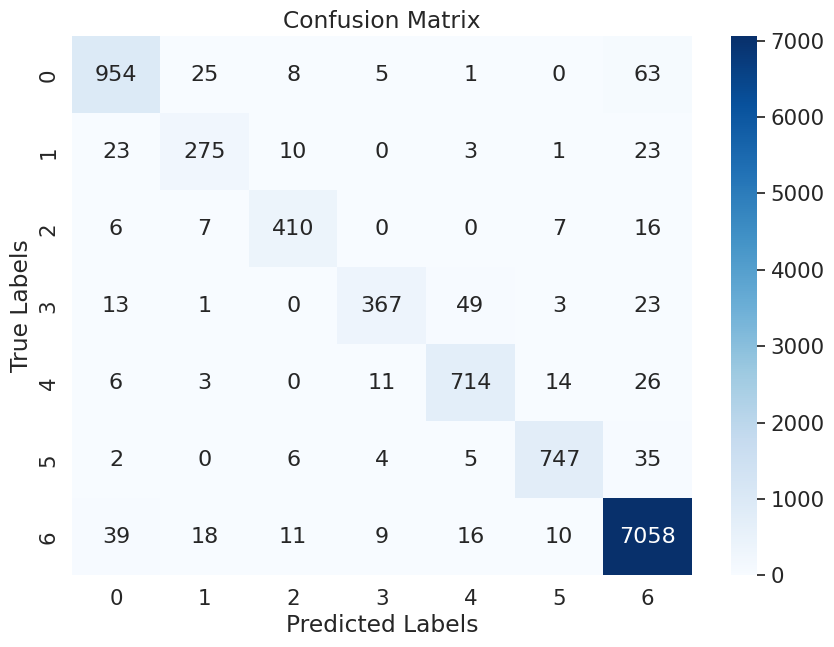

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from indicnlp.tokenize import indic_tokenize
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import wandb
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import wandb

class NERDataset(Dataset):
    def __init__(self, dataframe, ft_model, tokenizer, tag_to_index):
        self.dataframe = dataframe
        self.ft_model = ft_model
        self.tokenizer = tokenizer
        self.tag_to_index = tag_to_index

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        tokens = self.dataframe.iloc[idx]['tokens']
        ner_tags = self.dataframe.iloc[idx]['ner_tags']
        
        embeddings = [self.ft_model.get_word_vector(token) for token in tokens]
        embeddings = torch.tensor(embeddings, dtype=torch.float)

        tag_indices = [self.tag_to_index[tag] for tag in ner_tags]
        tag_indices = torch.tensor(tag_indices, dtype=torch.long)

        return embeddings, tag_indices
    
def collate_fn(batch):
    embeddings, tags = zip(*batch)
    embeddings_padded = pad_sequence(embeddings, batch_first=True, padding_value=0)
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=-1) 

    return embeddings_padded, tags_padded


tag_to_index = {tag: idx for idx, tag in enumerate(np.unique(train_df['ner_tags'].explode().values))}

train_dataset = NERDataset(train_df, ft_model, indic_tokenize.trivial_tokenize, tag_to_index)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataset = NERDataset(test_df, ft_model, indic_tokenize.trivial_tokenize, tag_to_index)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

class ELMoForNER(nn.Module):
    def __init__(self, elmo_model, hidden_dim, num_tags):
        super(ELMoForNER, self).__init__()
        self.elmo_model = elmo_model
        self.lstm = nn.LSTM(300, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_tags)

    def forward(self, x):
        _, _, elmo_embeddings = self.elmo_model(x)
        lstm_out, _ = self.lstm(elmo_embeddings)
        out = self.fc(lstm_out)
        return out


num_tags = len(tag_to_index)  
hidden_dim = 150

combined_model = ELMoForNER(elmo_model, hidden_dim, num_tags).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.001)


wandb.init(project='ELMO_FOR_INDIAN_LANGUAGES_GROUP-30', name="Downtask4-Train_elmo_Marathi")

for epoch in range(5):
    combined_model.train()
    total_loss = 0
    for embeddings, tags in tqdm(train_loader):
        embeddings, tags = embeddings.to(device), tags.to(device)

        optimizer.zero_grad()
        outputs = combined_model(embeddings)
        loss = criterion(outputs.view(-1, num_tags), tags.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    wandb.log({"train_loss": total_loss / len(train_loader)})
    print(f"Epoch {epoch+1}: Loss {total_loss / len(train_loader)}")


def evaluate_accuracy_elmo(model, data_loader, device):
    model.eval()
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for embeddings, tags in tqdm(data_loader):
            embeddings, tags = embeddings.to(device), tags.to(device)
            
            outputs = model(embeddings)
            outputs = outputs.cpu().detach().numpy() 
            tags = tags.cpu().detach().numpy()
            
            for i in range(outputs.shape[0]):  
                valid_length = int((tags[i] >= 0).sum())  
                all_outputs.extend(outputs[i, :valid_length].tolist())  
                all_labels.extend(tags[i, :valid_length].tolist()) 

    return np.array(all_outputs), np.array(all_labels)

# ====================================================================================
train_embeddings, train_labels = evaluate_accuracy_elmo(combined_model, train_loader, device)
predicted_labels_train = np.argmax(train_embeddings, axis=1)
print(classification_report(train_labels, predicted_labels_train))
cm = confusion_matrix(train_labels, predicted_labels_train)

plt.figure(figsize=(10, 7))  
sns.set(font_scale=1.4)  
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap=plt.cm.Blues)  
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# =====================================================================================
test_embeddings, test_labels = evaluate_accuracy_elmo(combined_model, test_loader, device)
predicted_labels = np.argmax(test_embeddings, axis=1)

print(classification_report(test_labels, predicted_labels))

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))  
sns.set(font_scale=1.4)  
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap=plt.cm.Blues)  

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()